<a href="https://colab.research.google.com/github/sridhartroy/AIML/blob/main/myPMFriend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI-based Project Management Task Delay prediction tool.

In [9]:
# Import basic libraries.
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.inspection import permutation_importance
import joblib, os
from datetime import date, timedelta
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(8,4)


## Step 1 : Generate Synthetic data ; make it as non-linear as possible.

In [13]:
rng = np.random.default_rng(6579)
n = 8000  # historical rows

df = pd.DataFrame({
    'story_points': rng.integers(1, 13, n),
    'effort_days': rng.uniform(1, 15, n),
    'num_dependencies': rng.integers(0, 6, n),
    'team_load': rng.uniform(0.6, 1.5, n),
    'complexity': rng.uniform(0.01, 1, n),
    'bug_count_recent': rng.poisson(2, n),
    'risk_tagged': rng.integers(0, 2, n),
    'dev_exp': rng.uniform(0.5, 10, n),
    'priority': rng.integers(1, 5, n),
    'sprint_day': rng.integers(1, 15, n),
    'cross_component': rng.integers(0, 2, n),
    'requirement_churn': rng.uniform(0, 1, n),
})

# To make it as non-linear as possible; this can be avoided.
logit = (
    0.6*df['num_dependencies'] + 1.0*(df['team_load']-1) + 0.8*df['complexity']
    + 0.40*df['bug_count_recent'] + 0.7*df['risk_tagged'] - 0.3*df['dev_exp'] + 0.5*df['cross_component'] + 0.9*df['requirement_churn']
)

p = 1/(1+np.exp(-(logit-1.2)))

df['delayed'] = (rng.random(n) < p).astype(int)

# Add project & due_date for real filtering
projects = [f'Project {i}' for i in range(1,6)]
df['project'] = rng.choice(projects, size=n, p=[0.20,0.25,0.18,0.22,0.15])
today = date.today()
start = today - timedelta(days=180)

offset = rng.integers(0, 180, size=n)

df['due_date'] = pd.to_datetime(start) + pd.to_timedelta(offset, unit='d')

df.head()


,story_points,effort_days,num_dependencies,team_load,complexity,bug_count_recent,risk_tagged,dev_exp,priority,sprint_day,cross_component,requirement_churn,delayed,project,due_date
0,6,4.382803,3,1.282016,0.803051,3,1,2.319629,4,8,0,0.814096,1,Project 2,2025-05-27
1,4,6.079948,2,1.094856,0.407023,1,1,8.542300,3,8,0,0.415871,0,Project 4,2025-05-30
2,5,13.024721,2,1.477427,0.983508,0,0,3.090146,4,2,1,0.905151,1,Project 3,2025-04-30
3,7,13.360213,4,0.647493,0.189737,5,0,2.861021,3,12,1,0.536174,1,Project 4,2025-03-04
4,5,3.984650,1,1.381739,0.083900,4,0,6.993037,4,6,1,0.099357,1,Project 2,2025-07-26


In [12]:
len(df)

8000

## Step 2) Use the synthetic data ; do split Train, Test with 70/30. Use Ensemble RandomClassifier and wrap it with calibration for the output proba.

In [15]:
FEATURES = ['story_points','effort_days','num_dependencies','team_load','complexity','bug_count_recent','risk_tagged','dev_exp',
            'priority','sprint_day','cross_component','requirement_churn']
X = df[FEATURES]
y = df['delayed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=6579, stratify=y)

rf = RandomForestClassifier(n_estimators=500, min_samples_split=4, min_samples_leaf=2, random_state=6579, n_jobs=-1, class_weight="balanced_subsample")

clf = CalibratedClassifierCV(rf, cv=3, method="sigmoid")
clf.fit(X_train, y_train)

# get predict proba and use that for the score with y_test.
y_proba = clf.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_proba)
print('Test ROC-AUC:', round(auc, 4))


Test ROC-AUC: 0.8024


## Optional for Review ) Permutation Importance - with scoring of AUC

,feature,importance_mean,importance_std
2,num_dependencies,0.141091,0.007981
7,dev_exp,0.084253,0.006820
5,bug_count_recent,0.039995,0.003426
6,risk_tagged,0.013004,0.001991
11,requirement_churn,0.008904,0.001396
10,cross_component,0.008076,0.001780
3,team_load,0.007845,0.001723
4,complexity,0.005671,0.002063
0,story_points,0.000906,0.001158
8,priority,0.000120,0.000580


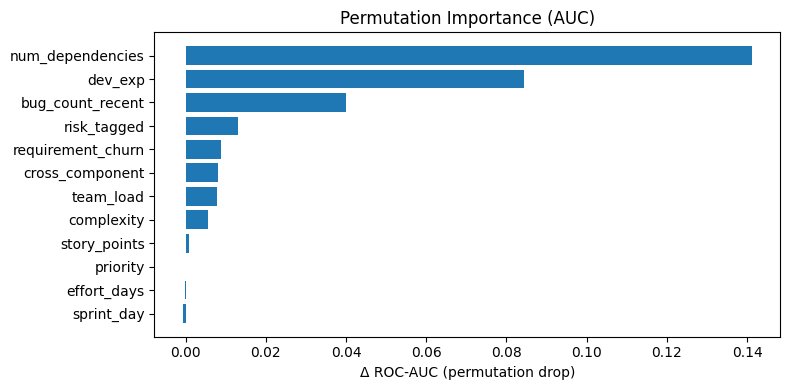

In [16]:
perm = permutation_importance(clf, X_test, y_test, scoring='roc_auc', n_repeats=30, random_state=6579, n_jobs=-1)
imp = pd.DataFrame({'feature': X_test.columns,
                    'importance_mean': perm.importances_mean,
                    'importance_std': perm.importances_std}).sort_values('importance_mean', ascending=False)

with pd.option_context('display.float_format','{:.6f}'.format):
    display(imp.head(15))

plt.figure()
order = np.argsort(imp['importance_mean'].values)
plt.barh(imp['feature'].values[order], imp['importance_mean'].values[order])
plt.xlabel('Δ ROC-AUC (permutation drop)'); plt.title('Permutation Importance (AUC)')
plt.tight_layout(); plt.show()


## Step 3) Save dataset, model for integrating with chatbot


In [17]:
from pathlib import Path

out_dir = Path('myPMFriend_V1'); out_dir.mkdir(exist_ok=True)
model_path = out_dir / 'myPMFriend_rf_calibrated_v1.joblib'
csv_path = out_dir / 'myPMFriend_synthetic_tasks_v1.csv'
joblib.dump(clf, model_path)
df.to_csv(csv_path, index=False)
model_path, csv_path

(PosixPath('myPMFriend_V1/myPMFriend_rf_calibrated_v1.joblib'),
 PosixPath('myPMFriend_V1/myPMFriend_synthetic_tasks_v1.csv'))

## Step 4) Inference demo for an unseen task


In [19]:
new_task = {
    'story_points': 8, 'effort_days': 8, 'num_dependencies': 4, 'team_load': 1.0,'complexity': 0.3, 'bug_count_recent': 2, 'risk_tagged': 1, 'dev_exp': 5.0,'priority': 3, 'sprint_day': 10, 'cross_component': 1,
    'requirement_churn': 0.6
}

X_new = pd.DataFrame([new_task])[FEATURES]
p_new = clf.predict_proba(X_new)[:,1][0]
print('Predicted delay probability:', round(float(p_new), 3))


Predicted delay probability: 0.922
